# CHAPTER 7 RNN을 이용한 문장 생성

**학습 내용**
- 언어 모델을 사용해 문장 생성을 수행
- seq2seq 구현

### 7.1 언어 모델을 사용한 문장 생성

#### RNN을 사용한 문장 생성의 순서
- 언어 모델은 다음에 출현할 단어의 확률 분포를 출력함
- 이 결과를 기초로 다음 단어를 생성하려면<br>
1. 확률이 가장 높은 단어를 선택하는 '결정적'인 방법과
2. 각 후보 단어의 확률에 맞게 선택하는 '확률적'인 방법이 있다. 
- 이를 반복한다

In [12]:
# 문장 생성 구현

import sys
sys.path.append("C:/Users/minjuKim/Desktop/[FIN_AI]_study_myself/deep-learning-from-scratch-2-master")
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)
        
#RnnlmGem 클래스를 사용한 문장 생성
from common.np import *
from ch07.rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('C:/Users/minjuKim/Desktop/[FIN_AI]_study_myself/deep-learning-from-scratch-2-master/ch06/BetterRnnlm.pkl')




In [14]:
# 더 좋은 문장으로 학습

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)


you get out of this era worked all said robert a planner with the donoghue 's association.
 you want to ask mr. phillips i 've got in one position in order to say and it now arrive before abc 's stock price and started up for nekoosa 's recent fall and over the next four months when you next year many of the projects were used.
 sotheby 's '80s said the disappointing deal was the result of a third announcement of the securities and exchange commission that no one saw the market during the summer morning.
 one
--------------------------------------------------
the meaning of life is that the earnings association see it.
 but a banning wang general was delayed.
 and they poured into on.
 within the past decade wang appears to end the mood at in the early 1980s to make financial institutions a money clash.
 the spirit question in a four-game band.
 instead of fashion the line the world series 's buses have just lost his short effect on the play on gorky of the poor.
 a lot more than placi

실행 할 때 마다 다른 문장 생성

### 7.2 seq2seq

#### seq2seq의 원리

Encoder-Decoder 모델이라고도 불리는 것 처럼, Encoder와 Decoder가 협력하여 시계열 데이터를 다른 시계열 데이터로 변환하는 것

**전체 과정**

1. Encoder을 통해 문장을 고정 길이 벡터로 인코딩
![1](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FnHlKt%2FbtqU7bUzXfj%2Fpb18xAWsvY8RnNmCiz5PU0%2Fimg.png)

2. 앞 절의 신경망과 완전히 같은 구성에서 LSTM 계층이 벡터 h를 입력 받는 Decoder계층으로 이동하여 문장 생성

#### 가변 길이 시계열 데이터

가변 길이 시계열 데이터를 미니배치로 학습하기 위한 가장 단순한 방법은 **패딩**을 사용하는 것<br>
**패딩** ? 원래의 데이터에 의미 없는 데이터를 채워 모든 데이터의 길이를 균일하게 맞추는 기법



In [15]:
# 덧셈 데이터 셋

from dataset import sequence


(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


### 7.3 seq2seq 구현

In [16]:
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled



| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 6[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 7[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 8[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 10[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 11[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 13[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 15[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 16[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 17[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q

| 에폭 8 |  반복 341 / 351 | 시간 21[s] | 손실 1.05
Q 77+85  
T 162 
X 166 
---
Q 975+164
T 1139
X 1160
---
Q 582+84 
T 666 
X 668 
---
Q 8+155  
T 163 
X 173 
---
Q 367+55 
T 422 
X 438 
---
Q 600+257
T 857 
X 873 
---
Q 761+292
T 1053
X 1073
---
Q 830+597
T 1427
X 1449
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 253 
---
검증 정확도 2.880%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 1.05
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 1.02
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 101 / 351 | 시간 6[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 7[s] | 손실 0.99
| 에폭 9 |  반복 141 / 351 | 시간 8[s] | 손실 0.99
| 에폭 9 |  반복 161 / 351 | 시간 9[s] | 손실 1.01
| 에폭 9 |  반복 181 / 351 | 시간 11[s] | 손실 0.99
| 에폭 9 |  반복 201 / 351 | 시간 12[s] | 손실 0.98
| 에폭 9 |  반복 221 / 351 | 시간 13[s] | 손실 0.98
| 에폭 9 |  반복 241 / 351 | 시간 14[s] | 손실 0.99
| 에폭 9 |  반복 261 / 351 | 시간 16[s] | 손실 0.99
| 에폭 9 |  반복 281 / 351 | 시간 17[s] | 손실 0.98
| 에폭 9 |  반복 301 

| 에폭 16 |  반복 121 / 351 | 시간 7[s] | 손실 0.89
| 에폭 16 |  반복 141 / 351 | 시간 8[s] | 손실 0.87
| 에폭 16 |  반복 161 / 351 | 시간 9[s] | 손실 0.88
| 에폭 16 |  반복 181 / 351 | 시간 10[s] | 손실 0.87
| 에폭 16 |  반복 201 / 351 | 시간 12[s] | 손실 0.84
| 에폭 16 |  반복 221 / 351 | 시간 13[s] | 손실 0.85
| 에폭 16 |  반복 241 / 351 | 시간 14[s] | 손실 0.91
| 에폭 16 |  반복 261 / 351 | 시간 15[s] | 손실 0.88
| 에폭 16 |  반복 281 / 351 | 시간 17[s] | 손실 0.89
| 에폭 16 |  반복 301 / 351 | 시간 18[s] | 손실 0.86
| 에폭 16 |  반복 321 / 351 | 시간 19[s] | 손실 0.83
| 에폭 16 |  반복 341 / 351 | 시간 20[s] | 손실 0.85
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1129
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
X 158 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1049
---
Q 830+597
T 1427
X 1418
---
Q 26+838 
T 864 
X 862 
---
Q 143+93 
T 236 
X 235 
---
검증 정확도 8.200%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.83
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.84
| 에폭 17 |  반복 41 / 351 | 시간 2[s] | 손실 0.86
| 에폭 17 |  반복 61 / 351 | 시간 3[s] | 손실 0.8

검증 정확도 10.120%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.75
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.81
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.78
| 에폭 24 |  반복 61 / 351 | 시간 3[s] | 손실 0.78
| 에폭 24 |  반복 81 / 351 | 시간 4[s] | 손실 0.78
| 에폭 24 |  반복 101 / 351 | 시간 5[s] | 손실 0.77
| 에폭 24 |  반복 121 / 351 | 시간 6[s] | 손실 0.78
| 에폭 24 |  반복 141 / 351 | 시간 8[s] | 손실 0.78
| 에폭 24 |  반복 161 / 351 | 시간 9[s] | 손실 0.81
| 에폭 24 |  반복 181 / 351 | 시간 10[s] | 손실 0.77
| 에폭 24 |  반복 201 / 351 | 시간 11[s] | 손실 0.77
| 에폭 24 |  반복 221 / 351 | 시간 12[s] | 손실 0.80
| 에폭 24 |  반복 241 / 351 | 시간 13[s] | 손실 0.77
| 에폭 24 |  반복 261 / 351 | 시간 15[s] | 손실 0.77
| 에폭 24 |  반복 281 / 351 | 시간 16[s] | 손실 0.79
| 에폭 24 |  반복 301 / 351 | 시간 17[s] | 손실 0.82
| 에폭 24 |  반복 321 / 351 | 시간 18[s] | 손실 0.76
| 에폭 24 |  반복 341 / 351 | 시간 19[s] | 손실 0.77
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1127
---
Q 582+84 
T 666 
X 655 
---
Q 8+155  
T 163 
X 167 
---
Q 367+55 
T 422 
X 415 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 105

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50640 missing from c

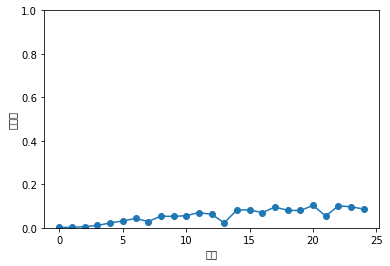

In [20]:
#seq2seq평가

import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
 model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()



| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.49
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.84
| 에폭 1 |  반복 101 / 351 | 시간 4[s] | 손실 1.80
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.79
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.77
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.77
| 에폭 1 |  반복 181 / 351 | 시간 10[s] | 손실 1.76
| 에폭 1 |  반복 201 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 221 / 351 | 시간 14[s] | 손실 1.75
| 에폭 1 |  반복 241 / 351 | 시간 15[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 17[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 18[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 20[s] | 손실 1.73
| 에폭 1 |  반복 321 / 351 | 시간 22[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 23[s] | 손실 1.73
Q 77+85  
T 162 
X 107 
---
Q 975+164
T 1139
X 1011
---
Q 582+84 
T 666 
X 103 
---
Q 8+155  
T 163 
X 101 
---
Q 367+55 
T 422 
X 103 
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1011
---

| 에폭 8 |  반복 321 / 351 | 시간 36[s] | 손실 0.73
| 에폭 8 |  반복 341 / 351 | 시간 38[s] | 손실 0.71
Q 77+85  
T 162 
X 164 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 665 
---
Q 8+155  
T 163 
X 160 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 849 
---
Q 761+292
T 1053
X 1037
---
Q 830+597
T 1427
X 1437
---
Q 26+838 
T 864 
X 869 
---
Q 143+93 
T 236 
X 231 
---
검증 정확도 12.480%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.70
| 에폭 9 |  반복 21 / 351 | 시간 2[s] | 손실 0.70
| 에폭 9 |  반복 41 / 351 | 시간 4[s] | 손실 0.70
| 에폭 9 |  반복 61 / 351 | 시간 7[s] | 손실 0.70
| 에폭 9 |  반복 81 / 351 | 시간 9[s] | 손실 0.70
| 에폭 9 |  반복 101 / 351 | 시간 11[s] | 손실 0.69
| 에폭 9 |  반복 121 / 351 | 시간 14[s] | 손실 0.69
| 에폭 9 |  반복 141 / 351 | 시간 16[s] | 손실 0.68
| 에폭 9 |  반복 161 / 351 | 시간 18[s] | 손실 0.68
| 에폭 9 |  반복 181 / 351 | 시간 21[s] | 손실 0.67
| 에폭 9 |  반복 201 / 351 | 시간 23[s] | 손실 0.68
| 에폭 9 |  반복 221 / 351 | 시간 25[s] | 손실 0.67
| 에폭 9 |  반복 241 / 351 | 시간 27[s] | 손실 0.67
| 에폭 9 |  반복 261 / 351 | 시간 30[s] | 손실 0.67
| 에폭 9 |  반복

| 에폭 16 |  반복 81 / 351 | 시간 8[s] | 손실 0.44
| 에폭 16 |  반복 101 / 351 | 시간 10[s] | 손실 0.44
| 에폭 16 |  반복 121 / 351 | 시간 13[s] | 손실 0.43
| 에폭 16 |  반복 141 / 351 | 시간 15[s] | 손실 0.44
| 에폭 16 |  반복 161 / 351 | 시간 17[s] | 손실 0.43
| 에폭 16 |  반복 181 / 351 | 시간 19[s] | 손실 0.43
| 에폭 16 |  반복 201 / 351 | 시간 22[s] | 손실 0.42
| 에폭 16 |  반복 221 / 351 | 시간 24[s] | 손실 0.43
| 에폭 16 |  반복 241 / 351 | 시간 26[s] | 손실 0.44
| 에폭 16 |  반복 261 / 351 | 시간 28[s] | 손실 0.43
| 에폭 16 |  반복 281 / 351 | 시간 30[s] | 손실 0.42
| 에폭 16 |  반복 301 / 351 | 시간 32[s] | 손실 0.43
| 에폭 16 |  반복 321 / 351 | 시간 34[s] | 손실 0.45
| 에폭 16 |  반복 341 / 351 | 시간 36[s] | 손실 0.44
Q 77+85  
T 162 
X 163 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1048
---
Q 830+597
T 1427
X 1429
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 31.180%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.41
| 에폭 17 |  반복 21 / 351 | 시간 2[s] | 

| 에폭 23 |  반복 321 / 351 | 시간 36[s] | 손실 0.20
| 에폭 23 |  반복 341 / 351 | 시간 38[s] | 손실 0.19
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
X 1054
---
Q 830+597
T 1427
X 1436
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 70.680%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.18
| 에폭 24 |  반복 21 / 351 | 시간 2[s] | 손실 0.18
| 에폭 24 |  반복 41 / 351 | 시간 4[s] | 손실 0.18
| 에폭 24 |  반복 61 / 351 | 시간 6[s] | 손실 0.18
| 에폭 24 |  반복 81 / 351 | 시간 8[s] | 손실 0.17
| 에폭 24 |  반복 101 / 351 | 시간 11[s] | 손실 0.18
| 에폭 24 |  반복 121 / 351 | 시간 13[s] | 손실 0.17
| 에폭 24 |  반복 141 / 351 | 시간 15[s] | 손실 0.17
| 에폭 24 |  반복 161 / 351 | 시간 17[s] | 손실 0.17
| 에폭 24 |  반복 181 / 351 | 시간 20[s] | 손실 0.18
| 에폭 24 |  반복 201 / 351 | 시간 22[s] | 손실 0.18
| 에폭 24 |  반복 221 / 351 | 시간 24[s] | 손실 0.17
| 에폭 24 |  반복 241 / 351 | 시간 26[s] | 손실 0.18
| 에폭 24 |  반복 261 / 351 | 시간 29[s] | 손실 0

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50640 missing from c

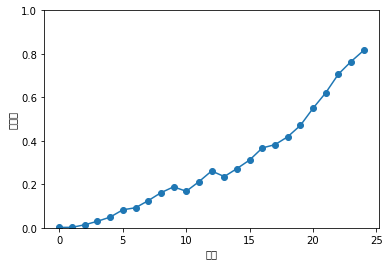

In [22]:
#seq2seq평가

import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()

### 7.4 seq2seq 개선

seq2seq을 세분화 하여 학습 '속도'를 개선하는 두가지 개선안
1. 입력 데이터 반전
2. 엿보기(peeky)

### 정리
- RNN을 이용한 언어 모델은 새로운 문장을 생성할 수 있다
- 문장을 생성할 때는 하나의 단어(혹은 문자)를 주고 모델의 출력(확률 분포)에서 샘플링 하는 과정을 반복한다
- RNN을 2개 조합함으로써 시계열 데이터를 다른 시계열 데이터로 변환할 수 있다.
- seq2seq는 Encoder가 출발어 입력문을 인코딩하고, 인코딩된 정보를 Decoder가 받아 디코딩하여 도착어 출력문을 얻는다
- 입력문을 반전시키는 기법(Reverse), 또는 인코딩된 정보를 Decoder의 여러 계층에 전달하는 기법(Peeky)는 seq2seq 정확도 향상에 효과적이다
- 기계 번역, 챗봇, 이미지 캡셔닝 등 seq2seq은 다양한 어플리케이션에 이용할 수 있다
